In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

import plotly.io as pio
import plotly.offline as pyo
import plotly.express as px


In [2]:
pio.renderers.default = 'notebook+jupyterlab+pdf'

pyo.init_notebook_mode(connected=True)

## Acerca las librerías no antes usadas.

### XGBoost

El cual es la abreviatura del inglés sXtreme Gradient Boosting, de acuerdo a la documentación del mismo, "es una biblioteca optimizada de aumento de gradiente distribuido diseñada para ser altamente eficiente, flexible y portátil . Implementa algoritmos de aprendizaje automático bajo el marco de Gradient Boosting"[1]

Esta librería utiliza arboles de decisión y técnicas de aprendizaje de refuerzo para mejorar el rendicmiento predictivo y de clasificación, es altamente utilizado en campos como las finanzas y salud.

## Información sobre el Dataset
*Los cardiotocogramas* (CTG) son una manera de evaluar la salud del feto, a través del monitoreo de la frecuencia cardiaca de éste y las contracciones uterinas de la madre, permite el tomar acción y prevenir la mortalidad infantil. Esto, a traves de leer sensores de ultrasonido para conocer el ritmo cardiaco del feto, y un tocógrafo para registrar las contracciones uterinas. [2]


El dataste esta compuesto de 40 variables y 2126 registros extraidos de exámenes de cardiotogramas, que fueron clasificados de dos maneras, una con respecto al patrón morfológico (A, B, C. ...) y de acuerdo al estado fetal (N, S, P):

Cabe mencionar que cuando se mencione "SisPorto", se refiere al sistema y evaluación de registros CTG desarrollado por la Universidad de Oporto en Portugal.

### Variables: Datos numéricos.

Lista de variables (omitidas las primero cinco columnas para este estudio).

- *LBE: valor base Frecuencia Cardiaca (Médico Experto) 
- *LB: valor base Frecuencia Cardiaca (Generado por SisPorto[3])
- *AC: aceleraciones (SisPorto)
- *FM: movimiento fetal (SisPorto)
- *UC: contracciones uterinas (SisPorto)
- *DL: desaceleraciones leves
- *DS: desaceleraciones severas
- *DP: desaceleraciones prolongadas
- *DR: desaceleraciones repetitivas

#### Producto de un pre'análisis por parte de SisPorto

- *ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)
- *mSTV: valor medio de la variabilidad a corto plazo (SisPorto)
- *ALTV: porcentaje de tiempo con variabilidad a largo plazo anormal (SisPorto)
- *mLTV: valor medio de la variabilidad a largo plazo (SisPorto)

#### Números del Histograma

- *Ancho: anchura del histograma
- *Mín: frecuencia baja del histograma
- *Máx: frecuencia alta del histograma
- *Nmax: número de picos del histograma
- *Nzeros: número de ceros del histograma
- *Moda: moda del histograma
- *Media: media del histograma
- *Mediana: mediana del histograma
- *Varianza: varianza del histograma
- *Tendencia: tendencia del histograma: -1=asimétrica a la izquierda; 0=simétrica; 1=asimétrica a la derecha

### Clasificación por Patrón Morfológico de 10 Clases, resumida en la columna CLASS
- A: Patrón de sueño tranquilo
- B: Patrón de sueño REM
- C: vigilia tranquila
- D: vigilia activa
- SH: patrón de cambio (A o Susp con cambios)
- AD: patrón acelerativo/decelerativo (situación de estrés)
- DE: patrón decelerativo (estimulación vagal)
- LD: patrón ampliamente decelerativo
- FS: patrón plano-sinusoidal (estado patológico)
- SUSP: patrón sospechoso
- CLASS: código de clase (de 1 a 10) para las clases de A a SUSP

### Clasificación por Estado del Feto de 3 Clases, resumida en la columna NSP
- NSP: Normal=1; Sospechoso=2; Patológico=3


In [3]:
#utilitario para ignorar Warnings, no tomar en cuenta para el reporte final
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
#utilitario para dar formato a las tablas al estilo 'ggplot' de R
plt.style.use('ggplot')

## Análisis Exploratorio de los Datos.

Sin caer en trivialiadades (todos los datos de la tabla son numéricos), haremos una diferención entre ellos de acuerdo a su origen, así, tenemos los datos producto de la Toma de datos de los instrumentos, otros derivados de un cálculo, por ejemplo, un valor promedio, que al provenir de los datos tomados, poseen cierta correlación y por ende podrían inducir a un bias, otros relacionados a lo que parece cierto pre'análsis estadístico a modo de histograma y por último dos tipos de clases. La naturaleza del origen de los datos nos puedan dar indicios acerca de su correlación.

In [3]:
###Se carga la base de datos completa a ser utilizada para el estudio
data = pd.read_csv('CTG.csv')

###Removemos las primeras cinco columnas que poseen la información Administrativa del proceso de estudio.
data = data.drop(columns=['FileName', 'Date', 'SegFile', 'b', 'e'])

###Dejaremos a éste punto el resto de los datos, tener en cuenta lo que se comentó anteriormente en relación aquellos que son producto de la ´Toma de Datos´

data.head()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


In [4]:
###Verificamos rápidamente la información general de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   float64
 1   LB        2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2127 non-null   float64
 4   UC        2127 non-null   float64
 5   ASTV      2127 non-null   float64
 6   MSTV      2127 non-null   float64
 7   ALTV      2127 non-null   float64
 8   MLTV      2127 non-null   float64
 9   DL        2128 non-null   float64
 10  DS        2128 non-null   float64
 11  DP        2128 non-null   float64
 12  DR        2128 non-null   float64
 13  Width     2126 non-null   float64
 14  Min       2126 non-null   float64
 15  Max       2126 non-null   float64
 16  Nmax      2126 non-null   float64
 17  Nzeros    2126 non-null   float64
 18  Mode      2126 non-null   float64
 19  Mean      2126 non-null   float64
 20  Median    2126 non-null   floa

### Descripción de lo visto

Se notan que el número de filas no es uniforme, en su mayoría es de 2126, pero hay columnas con 2127, 2128.
Es necesario entender a que se debe, veamos el final de la tabla.

In [5]:
## Viendo el fondo de la tabla para identificar posibles datos extra.
data.tail()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,142.0,142.0,1.0,1.0,5.0,74.0,0.4,36.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,NaN,564.0,23.0,87.0,7.0,91.0,50.7,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por la naturaleza del estudio hay que darse cuenta que hay una diferencia entre datos nulos NaN y ceros, en algunas columnas, en especial la de ´Toma de Datos´, cero, poseen un valor a ser considerado, lo anterior, de nuevo, depende del tipo de dato, podemos apreciar que las filas extra podrían interpretarse como datos faltantes y por ello aparecen como NaN, de ser ese el caso, es mejor eliminarlos.

In [6]:
# Elimina las últimas 3 filas del Dataset
data = data.drop(data.index[-3:])

In [7]:
## Reinspeccionando la tabla.
data.tail()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2121,140.0,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2122,140.0,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2123,140.0,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,142.0,142.0,1.0,1.0,5.0,74.0,0.4,36.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
###Confirmamos cuantos valores nulos existen por columna
data.isnull().sum()
#data.isna().sum()

LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [9]:
###Optenemos una descripción General del Dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
LB,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
AC,2126.0,2.722484,3.560850,0.0,0.0,1.0,4.0,26.0
FM,2126.0,7.241298,37.125309,0.0,0.0,0.0,2.0,564.0
UC,2126.0,3.659925,2.847094,0.0,1.0,3.0,5.0,23.0
ASTV,2126.0,46.990122,17.192814,12.0,32.0,49.0,61.0,87.0
MSTV,2126.0,1.332785,0.883241,0.2,0.7,1.2,1.7,7.0
ALTV,2126.0,9.846660,18.396880,0.0,0.0,0.0,11.0,91.0
MLTV,2126.0,8.187629,5.628247,0.0,4.6,7.4,10.8,50.7
DL,2126.0,1.570085,2.499229,0.0,0.0,0.0,3.0,16.0


A continuación se puede ver la diferencia por dicho detalle, nótese que estamos usando los datos producto del proceso de Toma de Datos, detallado anteriormente, en esa diferencia se nota como se han afectado ciertos valores estadísticos, como lo es en el caso de FM o Movimiento Fetal.

| Datos Originales | Datos SIN NaN |
| ------------ | ------------ |
| ![Original](Imagenes\Original.png) | ![Sin NaN](Imagenes\SinNaN.png) |

Claro está, que esas filas eliminadas son hasta cierto punto obvias, lo cierto es que las tablas en general son tan grandes que una inspección visual es inútil, por ello vamos a seguir estudiando los datos para encontrar mas inconsistencias o anomalías.

Pero, iniciaremos con la obvia, que corresponde a las columnas LBE y LB, ambas corresponden a la Frecuencia Cardiaca del Feto, sólo que una es por parte del médico y la otra por parte del equipo del SisPorto, ambas columnas son mutuamente redundantes, ello se puede notar al ver los datos en la tabla anterior, por lo que se elimnará una de ellas.

De las imágenes anteriores podemos darnos cuenta que a pesar de que los NaN han sido eliminados, hay ciertos valores que dan evidencia de posibles anomalías. ese sigue siendo el caso de FM, si bien su promedio y desviación estándar fueron mejorados al remover los datos extra, todavía apreciamos que, mientras el valor máximo es de 564.0, su promedio es de tan sólo 7.50, de igual manera se podría sospechar de las columnas AC y UC, aunque no parece tan evidente como para FM, por eso aplicaremos técnicas de visualición para terminar de confirmar posibles outliers, y de ser el caso afirmativo, aplicar lo necesario para eliminarlos.

![Posibles Anomalías](Imagenes\outliers001.png)

Por otro lado, es interesante analizar los valores de las columnas de Desaceleraciones en general, DL, DS, DP y DR. Se nota que fuera de datos NaN, la cantidad de valores iguales a cero es tal que afecta las estadísticas, acá también es mejor aplicar técnicas de visualización para terminar de entender sus efectos o si son anomalías a eliminar.

Una razón por la cuál aplicando estadística simple no podemos determinar o concluir con certeza si estamos en la presencia de una anomalía es si la distribución de los datos para esa columna en particular no sigue una distribución normal, por ende, empezaremos por ello, viendo cada uno de los histogramas de los datos.

In [10]:
# Vamos a tener varias tablas para analizar

# La siguiente es para los Datos Tomados
data_tom = data.copy()

data_tom = data_tom.drop(columns=['A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS','NSP', 'Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])

In [11]:
from ipywidgets import interact
#create a histogram

#función paraa mostrar interactivamente los histograma, por conveniencia al ser muchos
def mhist(colm):
    plt.figure(figsize=(5, 3))
    plt.hist(data_tom[colm],bins=10,label=colm)
    #Formatos
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma {colm}')

interact(mhist, colm=data_tom.columns);

interactive(children=(Dropdown(description='colm', options=('LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'AL…

Al ver los histogramas confirmamos que LB y LBE son lo mismo, además que es la única columna que sigue una distribución normal.
Para FM se confirma que hay uno o varios outliers los cuales tenemos que identificar puntualmente y arreglar.
Para el resto de las columnas se confirma que debemos usar otras técnicas estadíticas y/o de visualización para datos no normales.

In [23]:
#Los siguientes son las columnas que utilizaremos para analizar cuales poseen outliers que han de ser eliminados

data_2FindOutl = data.copy()

data_2FindOutl = data_2FindOutl.drop(columns=['LB', 'ASTV','MSTV','ALTV','MLTV','A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS','NSP', 'Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])

Utilizaremos un Box-Plot, ésta es una de las mejores maneras de rápidamente identificar si los datos poseen anomalías, de encontrarse, en el siguiente apartado se hará lo necesario para elimnarlos.

In [24]:
#Box Plot

import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Función para mostrar un boxplot para una columna dada
def mostrar_boxplot(columna):
    plt.figure(figsize=(8, 6))
    plt.boxplot(data[columna])
    plt.xlabel(columna)
    plt.title(f'Boxplot: {columna}')
    plt.show()

#Para escoger las columnas
columnas = data_2FindOutl.columns

# Utiliza interact para crear un menú desplegable interactivo para seleccionar la columna
interact(mostrar_boxplot, columna=Dropdown(options=columnas));


interactive(children=(Dropdown(description='columna', options=('LBE', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR'…

Ahora, después de haber aplicado un análisis estadítico, haber graficado los hitogramas y Box-Plots, es recomendable ahora con certeza, hacer lo necesario para eliminar los datos anómalos del Dataset, sabemos que hay, lo que tenemos noción en éste momento es de cuales son, pultualmente hablando. Por ende, exploraremos varias técnicas de eliminación de anomalías en el siguiente apartado. 

# el análisis para los datos numéricos ya está terminado, sin embargo, falta el analisis de las categorias existentes

# <c>La siguiente parte corresponde al manejo de las Anomalias y Clustering</c>

## Lo visto a partir de la descripción general de los datos

El número de filas ahora es común para todo el set, 2126 datos, sabemos de la [Información sobre el Dataset](#información-sobre-el-dataset), que el mismo está conformado por diferente naturaleza de datos, los tomados, los calculados, los que hacen referencia a ciertas estadísticas propia de cada toma de datos, de las clases generadas para el estudio original.

Entre otras cosas podemos denotar que:

1. LBE y LB, aunque obtenidas de manera diferente, proporcional exactamente la misma información, al ser redundante podría eliminarse una de ellas.
2. LB, que correponde a la Frecuancia Cardiaca del Feto, posee una distribución simétrica alrededor de su mediana.

Pero, para poder tener una perspectiva mas completa de cómo se correlacional los datos es mejor graficarlos.


In [12]:
#Iniciamos con algunos estudios para entender como se comportan los datos

data_corr = data.copy()

In [121]:
data_corr = data_corr.drop(columns=['LBE'])

In [116]:
###Hacemos lo propio con las columnas que corresponde a las clasificaciones
data_corr = data_corr.drop(columns=['A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS'])

In [ ]:

###Removeremos los que corresponden a cálculos
data_uno = data.drop(columns=['ASTV','MSTV','ALTV','MLTV'])

In [115]:
###Ahora los correspondientes al estudio de datos que los investigadores hicieron que se resumen en el histograma
data_corr = data_corr.drop(columns=['Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])


<Axes: >

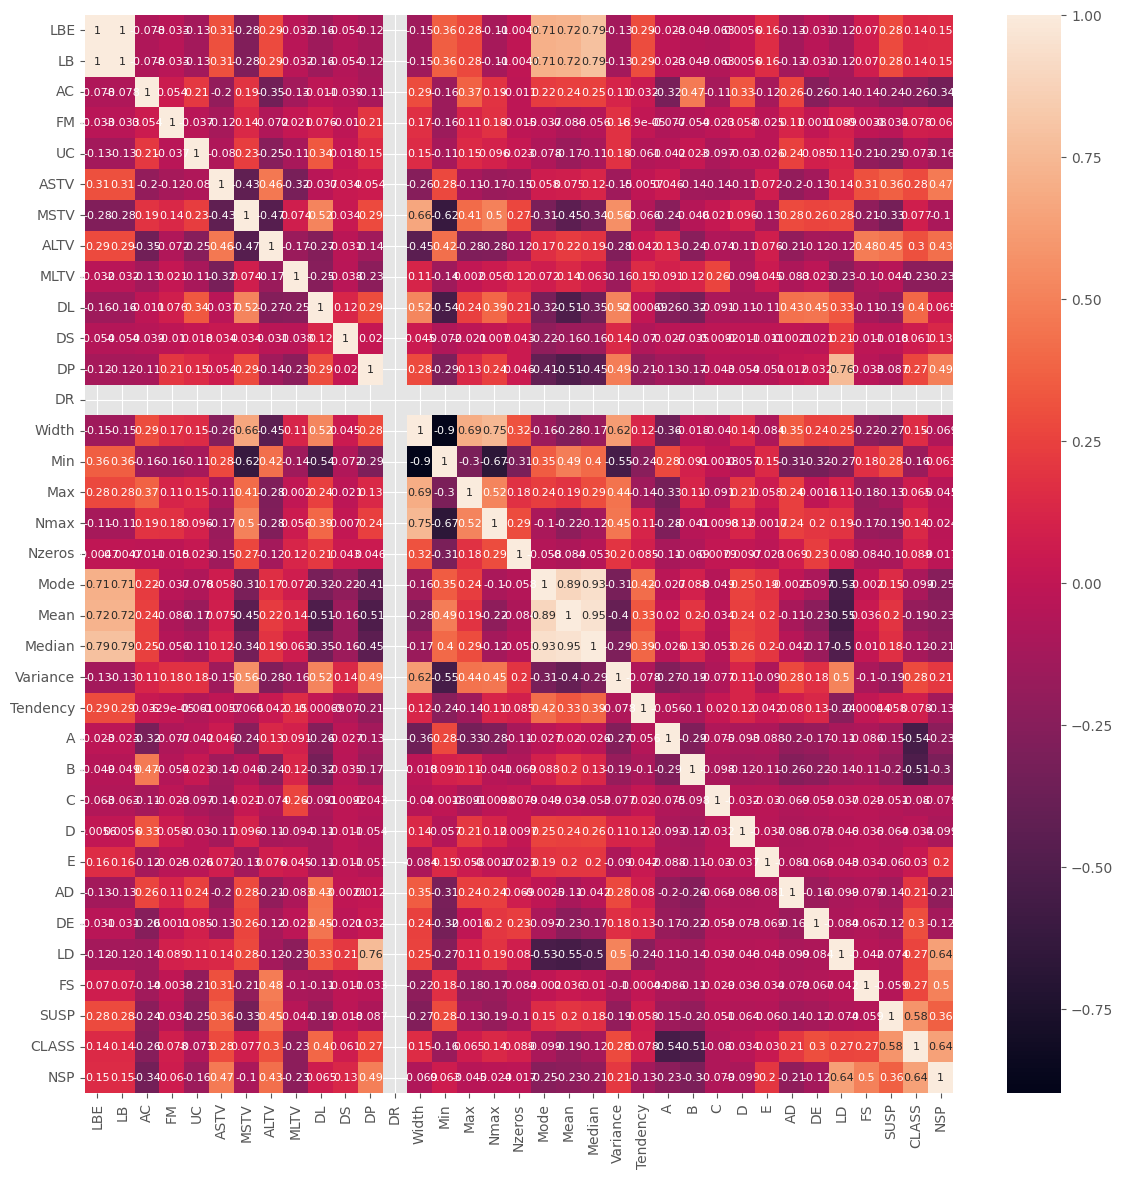

In [13]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(data_corr.corr(), annot=True, annot_kws={"size": 8})

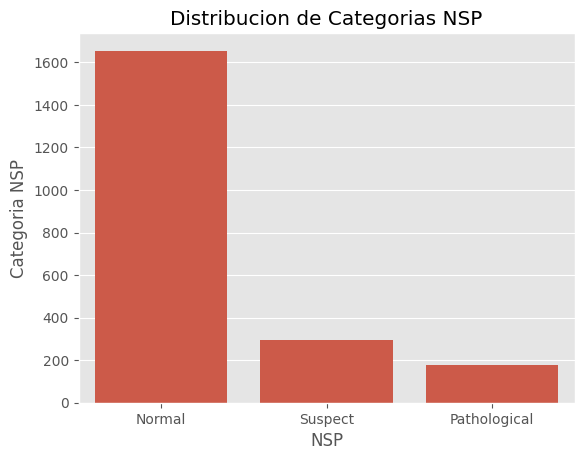

In [50]:
###Con el siguiente código se graficará la columna 'NSP' que corresponde a la clasificación
#we want to chart the column "NSP" from the file
plt.figure()
data_chart = data.copy()
data_chart['NSP'] = data['NSP'].replace({1: 'Normal', 2:'Suspect', 3:'Pathological'})
ax = sns.countplot(data=data_chart, x="NSP", order=["Normal", "Suspect", "Pathological"])
ax.set_title('Distribucion de Categorias NSP')
ax.set_ylabel('Casos')
ax.set_ylabel('Categoria NSP')
plt.show()

Nuestras clases estan inbalanceadas

## NOTA INTERNA>  Ojo con el comportamiento de DR

In [52]:
data_dos = data.drop(columns=['Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency','A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS']).corr()['NSP'].sort_values(ascending=False)

La matriz de correlaciones claramente muestra que hay un par de variables que estan altamente correlacionadas con nuestra variable objetivo NSP: 
1. LD - Patron ampliamente decelerativo
2. FS - patrón plano-sinusoidal (estado patológico)
3. DP - desaceleraciones prolongadas 
4. ASTV - porcentaje de tiempo con variabilidad a corto plazo anormal 
5. ALTV - porcentaje de tiempo con variabilidad a largo plazo anormal.
6. Variance - Varianza del histograma

Hagamos un analysis bivariado para entender el comportamiento


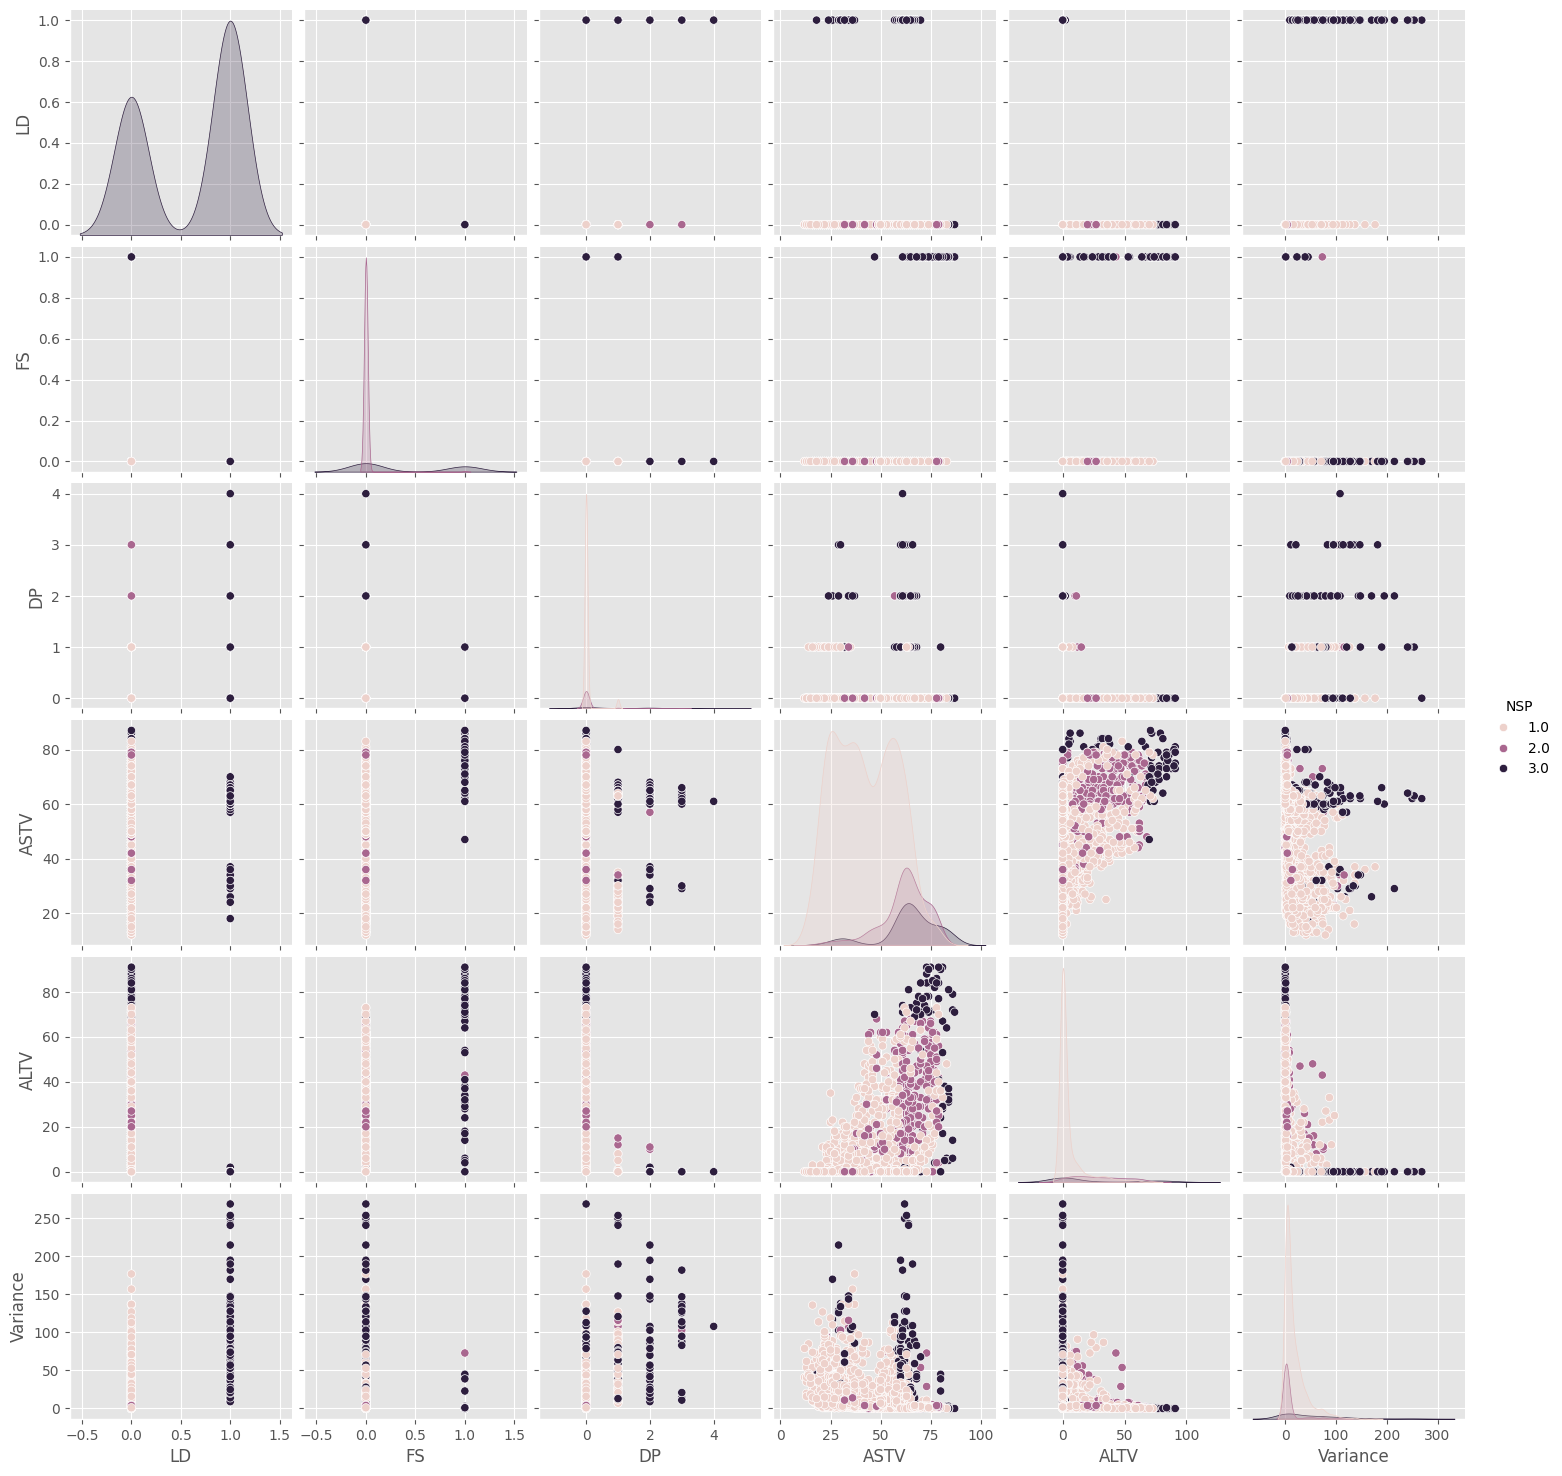

In [53]:
data_chart_vibar = data[['LD', 'FS', 'DP', 'ASTV', 'ALTV', 'Variance', 'NSP']]
sns.pairplot(data_chart_vibar, hue='NSP')

## Detección de anomalías

In [36]:
print('aqui va codigo')

aqui va codigo


## Agrupacion y modelado
### Primero vamos a seleccionar nuestros features mas importantes antes de entrenar un modelo
### Primero vamos a segregar los datos y a escalarlos
### <span style="color:red; font-family: Helvetica;">JGS:</span> Considerar usar sólo las variables consideradas 'Datos Numéricos' nombrados arriba

Primero hacemos el split de entrenamiento y validacion. Aplicaremos scaling al data set. Esto nos ayuda a reducir el efecto de outliers, tambien.

<Axes: xlabel='Score', ylabel='Feature'>

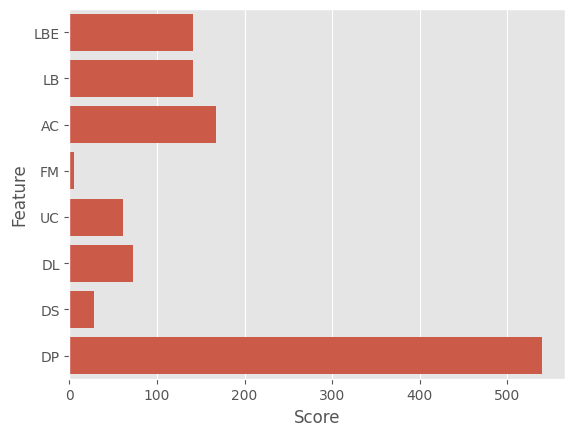

In [56]:
###Removeremos los que corresponden a cálculos
data_uno = data.drop(columns=['ASTV','MSTV','ALTV','MLTV'])
###Hacemos lo propio con las columnas que corresponde a las clasificaciones
data_uno = data_uno.drop(columns=['A','B','C','D','E','AD','DE','LD','FS','SUSP','CLASS'])
###Ahora los correspondientes al estudio de datos que los investigadores hicieron que se resumen en el histograma
data_uno = data_uno.drop(columns=['DR','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency'])

#data_non = data.dropna()
#X=data_non.drop(['SUSP', 'CLASS', 'NSP'], axis=1)
#Y=data_non['NSP']

X=data_uno.drop(['NSP'], axis=1)
Y=data_uno['NSP']

best = SelectKBest(score_func=f_classif, k='all')
fit = best.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
features = pd.concat([dfcolumns, dfscores], axis=1)
features.columns = ['Feature', 'Score']

sns.barplot(data=features, x='Score', y='Feature', orient='h')


Los resultados de este feature selection confirman lo que habiamos visto anteriormente, los features que principalmente comparten informacion son: LD, FS, DP, ASTV, ALTV, Mode, Mean, Median, E.
Seleccionaremos a todo lo que sea mayor a 200


In [57]:
feat_select = features[features['Score'] >= 200]
feat_select = list(feat_select['Feature'])
feat_select.append('NSP')
#model_data = data_non[feat_select]
model_data = data_uno[feat_select]
model_data

,DP,NSP
0,0.0,2.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
2121,0.0,2.0
2122,0.0,2.0
2123,0.0,2.0
2124,0.0,2.0


In [58]:
#Splitting
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(model_data.drop(['NSP'], axis=1), model_data['NSP'],test_size=0.25, random_state=2978,
                                                 stratify=model_data['NSP'])

#Scaling

scaler=preprocessing.StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test) 


In [59]:
#A quick model selection process
#pipelines of models( it is short was to fit and pred)
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=2978))])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=2978))])

# pipeline_xgb = Pipeline([('xgb_classifier', XGBClassifier(random_state=2978))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier())])

pipeline_svc=Pipeline([('sv_classifier',SVC())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'LogisticR', 1: 'DecTree', 2: "RandomForest", 3:"SVC"}


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train_scaled, y_train)

#cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LogisticR: 0.810554 
DecTree: 0.810554 
RandomForest: 0.810554 
SVC: 0.810554 


## Referencias

- [1] XGBoost Documentation. (s.f.). XGBoost Documentation. Recuperado de https://xgboost.readthedocs.io/en/stable/
- [2] CUN. (s.f.). Diccionario Médico. Recuperado de https://www.cun.es/diccionario-medico/terminos/cardiotocografia
- [3] SISPORTO. (s.f.). A Brief History of the SISPORTO Project. Recuperado de https://sisporto.med.up.pt/a-brief-history-of-the-sisporto-project/


